Nama: Muhammad Rizky Haritama Putra <br>
Nim: 2309106083<br>
Posttest 4

Import Library

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score


Buat ngebaca file csv dan mengubah nama kolom unnamed menjadi id

In [33]:
df = pd.read_csv("HepatitisCdata.csv")
df = df.rename(columns={'Unnamed: 0': 'ID'})


Ngecek apakah terdapat missing value, duplicate value, dan outlier

In [34]:
print("=== CEK MISSING VALUE ===")
#cek missing value
missing = df.isnull().sum()
print(missing)

=== CEK MISSING VALUE ===
ID           0
Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64


In [35]:
# Cek Duplicate Value
print("CEK DUPLICATE VALUE")
duplicate_count = df.duplicated().sum()
print(duplicate_count)

CEK DUPLICATE VALUE
0


In [36]:
#Cek Outlier (Metode IQR)
print("CEK OUTLIER (IQR METHOD)")

numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outliers} outlier")

CEK OUTLIER (IQR METHOD)
ID: 0 outlier
Age: 1 outlier
ALB: 27 outlier
ALP: 10 outlier
ALT: 36 outlier
AST: 64 outlier
BIL: 47 outlier
CHE: 24 outlier
CHOL: 12 outlier
CREA: 12 outlier
GGT: 65 outlier
PROT: 20 outlier


Kode diatas digunakan untuk memeriksa kualitas data sebelum analisis. Pengecekan missing value dilakukan untuk menemukan data kosong yang bisa memengaruhi hasil dan perlu ditangani. Pengecekan duplicate value mendeteksi data ganda yang bisa menimbulkan bias. Pengecekan outlier dengan metode IQR digunakan untuk menemukan nilai ekstrem di luar batas wajar yang dapat mengganggu pola data. Langkah ini penting agar dataset bersih, akurat, dan siap digunakan untuk analisis atau pemodelan.

##1. Data cleaning

In [37]:
#Tangani missing value khusus kolom tertentu
impute_cols = ['ALB', 'ALP', 'ALT', 'CHOL', 'PROT']
print("\n=== IMPUTASI NILAI HILANG ===")

for col in impute_cols:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"Kolom {col}: {missing_count} nilai hilang → diganti median = {median_val:.2f}")
        else:
            print(f"Kolom {col}: tidak ada nilai hilang ")
    else:
        print(f"Kolom {col} tidak ditemukan dalam dataset ")


=== IMPUTASI NILAI HILANG ===
Kolom ALB: 1 nilai hilang → diganti median = 41.95
Kolom ALP: 18 nilai hilang → diganti median = 66.20
Kolom ALT: 1 nilai hilang → diganti median = 23.00
Kolom CHOL: 10 nilai hilang → diganti median = 5.30
Kolom PROT: 1 nilai hilang → diganti median = 72.20


In [38]:
# Daftar kolom numerik yang akan diimputasi outliernya
kolom_outlier = ['Age', 'ALB', 'ALP', 'ALT', 'AST',
                 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']

# Fungsi imputasi outlier dengan median
def impute_outlier_iqr(df, kolom):
    Q1 = df[kolom].quantile(0.25)
    Q3 = df[kolom].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    median = df[kolom].median()

    # Ganti nilai di bawah lower dan di atas upper dengan median
    df.loc[df[kolom] < lower, kolom] = median
    df.loc[df[kolom] > upper, kolom] = median

# Terapkan ke semua kolom
for kolom in kolom_outlier:
    before = df[kolom].copy()
    impute_outlier_iqr(df, kolom)
    print(f"{kolom}: imputasi selesai (median={df[kolom].median():.2f})")

print("\nSemua outlier sudah diganti dengan median masing-masing kolom.")

Age: imputasi selesai (median=47.00)
ALB: imputasi selesai (median=41.95)
ALP: imputasi selesai (median=66.20)
ALT: imputasi selesai (median=23.00)
AST: imputasi selesai (median=25.90)
BIL: imputasi selesai (median=7.30)
CHE: imputasi selesai (median=8.26)
CHOL: imputasi selesai (median=5.30)
CREA: imputasi selesai (median=77.00)
GGT: imputasi selesai (median=23.30)
PROT: imputasi selesai (median=72.20)

Semua outlier sudah diganti dengan median masing-masing kolom.


In [39]:
# menyimpan data csv setelah di clean
df.to_csv("data_clean_HepatitisCdata.csv", index=False)

Kode ini menangani missing value dan outlier agar data lebih bersih. Nilai kosong di kolom tertentu diganti dengan median karena lebih stabil terhadap nilai ekstrem. Outlier dideteksi dengan metode IQR lalu diganti median agar distribusi data tetap wajar tanpa menghapus data. Langkah ini membuat dataset lebih konsisten dan siap dianalisis.

##2. Normalisasi / Standarisasi Kolom Numerik

In [40]:
# Baca dataset
df = pd.read_csv("data_clean_HepatitisCdata.csv")

In [41]:
# Normalisasi / standarisasi untuk kolom numerik
scaler = StandardScaler()
num_cols = ['Age','ALB', 'ALP', 'ALT', 'CHOL', 'PROT','AST','BIL','CHE','CREA','GGT']
df[num_cols] = scaler.fit_transform(df[num_cols])

print("\nKolom numerik telah distandarisasi.")
df[num_cols].head()


Kolom numerik telah distandarisasi.


,Age,ALB,ALP,ALT,CHOL,PROT,AST,BIL,CHE,CREA,GGT
0,-1.539675,-0.844293,-0.758827,-1.485073,-2.069345,-0.818096,-0.597660,-0.104753,-0.728265,1.966669,-0.925294
1,-1.539675,-0.844293,0.222981,-0.535580,-0.515308,0.946857,-0.216403,-1.035802,1.634733,-0.286894,-0.690955
2,-1.539675,1.150866,0.465675,1.142164,-0.119375,1.605772,-0.040439,-0.466828,0.336199,0.558192,0.487436
3,-1.539675,0.272046,-0.786406,0.625935,-0.574698,0.758595,-0.524342,2.843567,-0.505341,0.135649,0.527609
4,-1.539675,-0.678029,0.432580,0.810303,-0.990428,-0.888694,-0.201740,0.438358,0.508965,-0.146046,0.266488


In [42]:
#menyimpan data csv setelah di normalisasi
df.to_csv("data_normalisasi_HepatitisCdata.csv", index=False)

Kode ini melakukan standarisasi pada kolom numerik menggunakan StandardScaler. Proses ini mengubah setiap kolom agar memiliki rata-rata 0 dan standar deviasi 1, sehingga skala semua fitur menjadi sebanding. Standarisasi penting karena banyak algoritma machine learning sensitif terhadap perbedaan skala antarfitur. Dengan langkah ini, data menjadi lebih seimbang dan siap digunakan untuk analisis atau pemodelan.

##3. Encoding Kolom Kategorikal

In [43]:
# ngebaca file csv
df = pd.read_csv("data_normalisasi_HepatitisCdata.csv")

In [44]:
# Encode gender (f=0, m=1)
df["Sex"] = df["Sex"].astype(str).str.strip().str.lower().map({"f": 0, "m": 1})
print(df["Sex"].head())

0    1
1    1
2    1
3    1
4    1
Name: Sex, dtype: int64


In [45]:
df["Category"] = (
    df["Category"]
    .astype(str)
    .str.strip()
    .str.lower()
    .map({
        "0=blood donor": 0,
        "1=hepatitis": 1,
        "2=fibrosis": 2,
        "3=cirrhosis": 3,
        "0s=suspect blood donor": 4
    })
)
print(df["Category"].unique())

[0 4 1 2 3]


In [46]:
# menyimpan data csv setelah di encod
df.to_csv("data_encod_HepatitisCdata.csv", index=False)

Kode ini melakukan encoding pada kolom kategorik agar dapat diproses sebagai data numerik. Pada kolom Sex, nilai 'f' diubah menjadi 0 dan 'm' menjadi 1 agar bisa digunakan dalam analisis atau model. Sedangkan pada kolom Category, setiap kategori teks (seperti blood donor, hepatitis, fibrosis, dll.) dipetakan ke angka tertentu. Proses ini penting karena algoritma machine learning tidak dapat memproses data berupa teks, sehingga perlu diubah menjadi format numerik yang konsisten.

##4. Feature Engineering

In [47]:
#ngebaca file csv
df = pd.read_csv("data_encod_HepatitisCdata.csv")

In [48]:
# Rasio AST/ALT versi aman
df["AST_ALT_ratio"] = df["AST"] / (df["ALT"] + 1e-6)

# Gunakan nilai absolut agar tidak ada log negatif
df["log_AST_ALT_ratio"] = np.log(np.abs(df["AST_ALT_ratio"]) + 1e-6)

# Cek hasil kolom baru
print(df[["AST", "ALT", "AST_ALT_ratio", "log_AST_ALT_ratio"]].head())

# Cek korelasi dengan target Category
if "Category" in df.columns:
    corr = df[["AST_ALT_ratio", "log_AST_ALT_ratio", "Category"]].corr()
    print("\nKorelasi terhadap target Category:")
    print(corr["Category"].sort_values(ascending=False))

# Simpan dataset baru ke file CSV
df.to_csv("data_feature_HepatitisCdata.csv", index=False)

        AST       ALT  AST_ALT_ratio  log_AST_ALT_ratio
0 -0.597660 -1.485073       0.402445          -0.910193
1 -0.216403 -0.535580       0.404055          -0.906202
2 -0.040439  1.142164      -0.035405          -3.340870
3 -0.524342  0.625935      -0.837692          -0.177104
4 -0.201740  0.810303      -0.248968          -1.390427

Korelasi terhadap target Category:
Category             1.000000
AST_ALT_ratio       -0.024096
log_AST_ALT_ratio   -0.298636
Name: Category, dtype: float64


Kode ini membuat fitur baru untuk analisis. Kolom AST_ALT_ratio dihitung sebagai rasio AST / ALT untuk melihat keseimbangan kedua enzim hati. Ditambahkan nilai kecil 1e-6 agar tidak terjadi pembagian nol. Lalu dibuat kolom log_AST_ALT_ratio dengan logaritma dari nilai rasio untuk menstabilkan sebaran data dan menghindari log negatif.
Selanjutnya, dilakukan korelasi antara fitur baru dengan kolom target Category untuk mengecek seberapa besar hubungan rasio ini dengan label penyakit. Terakhir, dataset yang sudah diperbarui disimpan ke file CSV agar bisa digunakan untuk analisis atau pemodelan berikutnya.

##5. Splitting Data ke Training & Testing

In [49]:
#ngebaca file csv
df = pd.read_csv("data_feature_HepatitisCdata.csv")

In [50]:
# Pisahkan fitur (X) dan target (y)
X = df.drop(columns=["Category"])   # semua kolom kecuali target
y = df["Category"]                  # target (label kelas)

# Split data: 80% training, 20% testing (bisa disesuaikan)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tampilkan hasil
print("Ukuran dataset keseluruhan:", df.shape)
print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

df.to_csv("data_split_HepatitisCdata.csv", index=False)

Ukuran dataset keseluruhan: (615, 16)
Training set: (492, 15)
Testing set: (123, 15)


Kode ini digunakan untuk memisahkan data menjadi fitur dan target, lalu membagi dataset menjadi data latih dan data uji.
Pertama, variabel X berisi semua kolom kecuali Category sebagai fitur, sedangkan y hanya berisi kolom Category sebagai target (label). Kemudian, train_test_split digunakan untuk membagi data menjadi 80% untuk training dan 20% untuk testing dengan parameter stratify=y agar distribusi kelas target tetap seimbang di kedua subset.
Langkah ini penting agar model dapat belajar dari data latih dan diuji performanya pada data uji yang belum pernah dilihat, sehingga hasil evaluasi menjadi lebih objektif.

ngebaca file csv

In [51]:
df = pd.read_csv("data_split_HepatitisCdata.csv")

# A1. IMPLEMENTASI METODE KLASIFIKASI

In [52]:
# PEMISAHAN FITUR DAN LABEL
X = df.drop("Category", axis=1)
y = df["Category"]

In [53]:
# PEMBAGIAN DATA TRAINING & TESTING
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [54]:
# STANDARISASI DATA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
# TRAINING MODEL SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [56]:
# TRAINING MODEL RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

Pada tahap ini dilakukan penerapan algoritma klasifikasi karena label target pada dataset bersifat kategorikal. Model utama yang digunakan adalah Support Vector Classifier (SVM) yang bekerja dengan mencari batas pemisah terbaik antar kelas. Selain itu, ditambahkan juga model pembanding yaitu Random Forest Classifier untuk memperoleh hasil yang lebih komprehensif. Random Forest bekerja dengan menggabungkan banyak decision tree untuk menghasilkan prediksi yang lebih akurat dan stabil. Sebelum pelatihan model, data terlebih dahulu dibagi menjadi data training dan testing, lalu distandarisasi agar setiap fitur memiliki skala yang sama.

# A2. EVALUASI MODEL

In [57]:
# EVALUASI MODEL

print("=== EVALUASI SVM ===")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print("Akurasi SVM:", round(accuracy_score(y_test, y_pred_svm), 4))

print("\n=== EVALUASI RANDOM FOREST ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Akurasi Random Forest:", round(accuracy_score(y_test, y_pred_rf), 4))

=== EVALUASI SVM ===
[[107   0   0   0   0]
 [  1   3   0   1   0]
 [  2   1   1   0   0]
 [  1   0   1   4   0]
 [  1   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       0.75      0.60      0.67         5
           2       0.50      0.25      0.33         4
           3       0.80      0.67      0.73         6
           4       0.00      0.00      0.00         1

    accuracy                           0.93       123
   macro avg       0.60      0.50      0.54       123
weighted avg       0.92      0.93      0.92       123

Akurasi SVM: 0.935

=== EVALUASI RANDOM FOREST ===
[[107   0   0   0   0]
 [  0   3   1   1   0]
 [  0   0   4   0   0]
 [  0   0   0   6   0]
 [  0   0   1   0   0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       107
           1       1.00      0.60      0.75         5
           2       0.67      1.00      0.80 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Setelah model dilatih, dilakukan evaluasi untuk menilai seberapa baik performanya dalam memprediksi data uji. Evaluasi dilakukan menggunakan Confusion Matrix dan Classification Report. Confusion Matrix menunjukkan jumlah prediksi benar dan salah pada tiap kelas, sedangkan Classification Report menampilkan metrik seperti precision, recall, f1-score, dan akurasi. Hasil evaluasi ini digunakan untuk membandingkan performa antara model SVM dan Random Forest.

# A3. VISUALISASI HASIL PREDIKSI

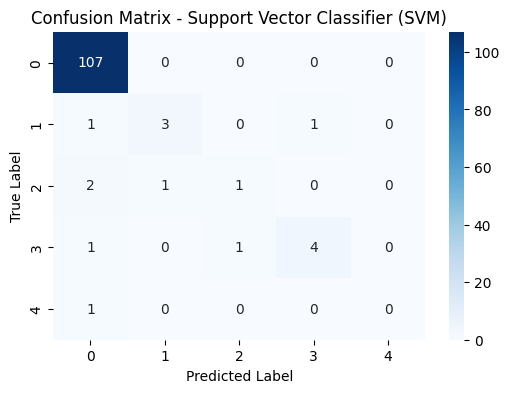

In [58]:
# VISUALISASI CONFUSION MATRIX
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Support Vector Classifier (SVM)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


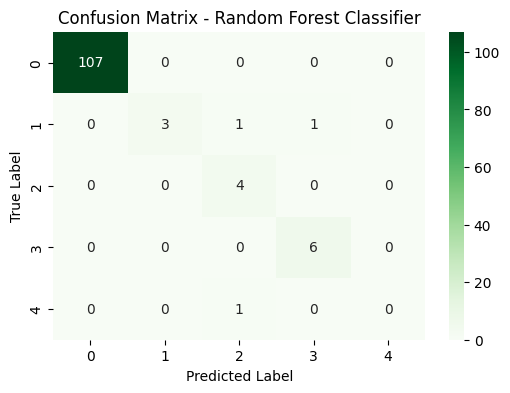

In [59]:
# --- Confusion Matrix untuk Random Forest ---
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


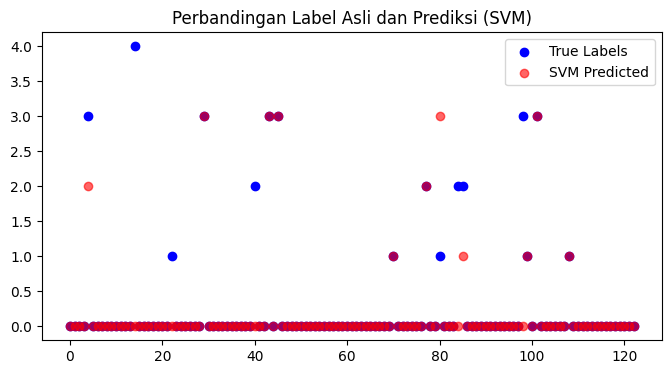

In [60]:
# VISUALISASI PERBANDINGAN LABEL ASLI DAN PREDIKSI
plt.figure(figsize=(8,4))
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Labels')
plt.scatter(range(len(y_pred_svm)), y_pred_svm, color='red', alpha=0.6, label='SVM Predicted')
plt.title("Perbandingan Label Asli dan Prediksi (SVM)")
plt.legend()
plt.show()

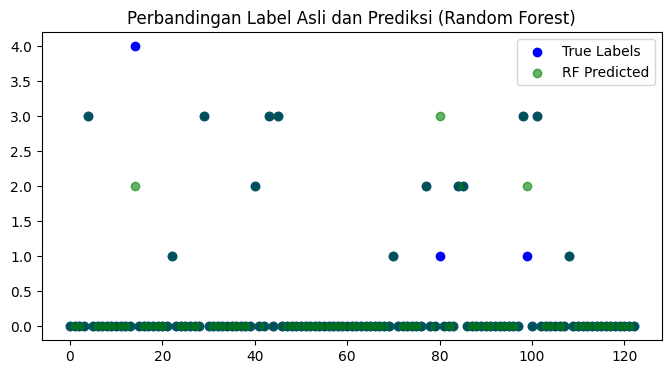

In [61]:
# --- Scatter Plot: Label Asli vs Prediksi (Random Forest) ---
plt.figure(figsize=(8,4))
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Labels')
plt.scatter(range(len(y_pred_rf)), y_pred_rf, color='green', alpha=0.6, label='RF Predicted')
plt.title("Perbandingan Label Asli dan Prediksi (Random Forest)")
plt.legend()
plt.show()

Tahap ini menampilkan hasil evaluasi model dalam bentuk grafik agar lebih mudah dipahami. Confusion Matrix divisualisasikan menggunakan heatmap sehingga perbedaan prediksi antar kelas terlihat jelas. Selain itu, dibuat juga scatter plot untuk memperlihatkan perbandingan antara label asli dan hasil prediksi pada setiap model. Dari grafik ini dapat dilihat sejauh mana hasil prediksi mendekati nilai sebenarnya, sehingga membantu dalam menilai keakuratan model secara visual.